In [58]:
import numpy as np
import os
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_4DLorenz.recursive_LSTM_PostMeanScore_4DLorenz_T256_H05_tl_110data import get_config

In [59]:
num_paths = 10952

In [60]:
def get_drift_files(config):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    global_files = []
    true_files = []
    local_files = []
    for file in os.listdir(root_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "global" in file:
                global_files.append(root_dir+file)
            elif "true" in file:
                true_files.append(root_dir+file)
            elif "local" in file:
                local_files.append(root_dir+file)
    assert len(global_files)>0, "No global files found"
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(global_files) == len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    global_files = sorted(global_files, key=extract_bw_number)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in global_files]
    return global_files, true_files, local_files, bws

In [61]:
config = get_config()
global_files, true_files, local_files, bws = get_drift_files(config=config)
global_files

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftEvalExp_001bw_10952NPaths_00t0_3906e-03dT_global_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftEvalExp_00127bw_10952NPaths_00t0_3906e-03dT_global_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftEvalExp_0016bw_10952NPaths_00t0_3906e-03dT_global_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftEvalExp_00203bw_10952NPaths_00t0_3906e-03dT_global_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftEvalExp_00257bw_10952NPaths_00t0_3906e-03dT_global_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftEvalExp_00326bw_10952NPaths_00t0_3906e-03dT_global_states.npy',
 '/Users/marcos/GitHubRepos/Fractiona

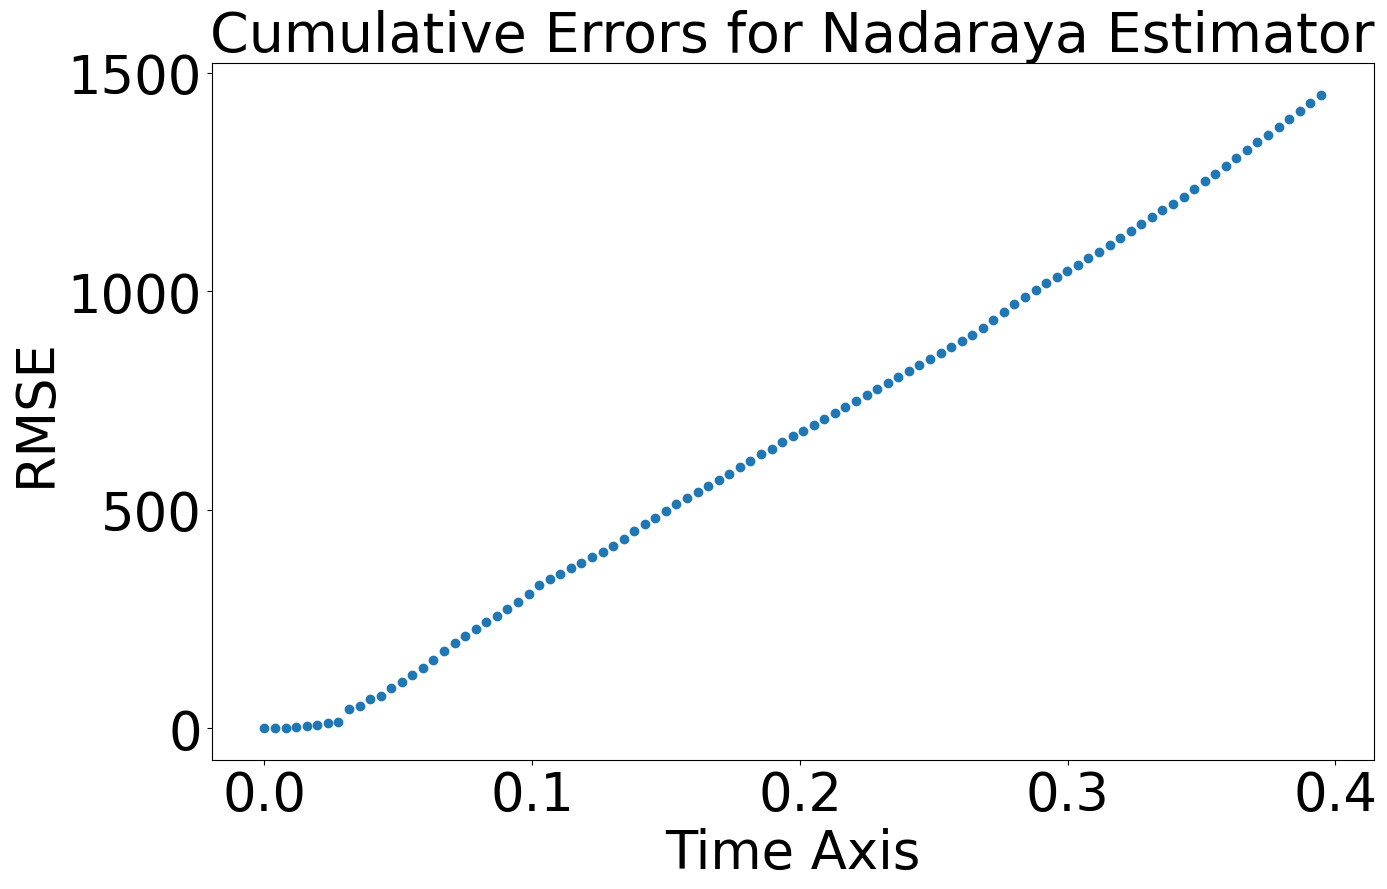

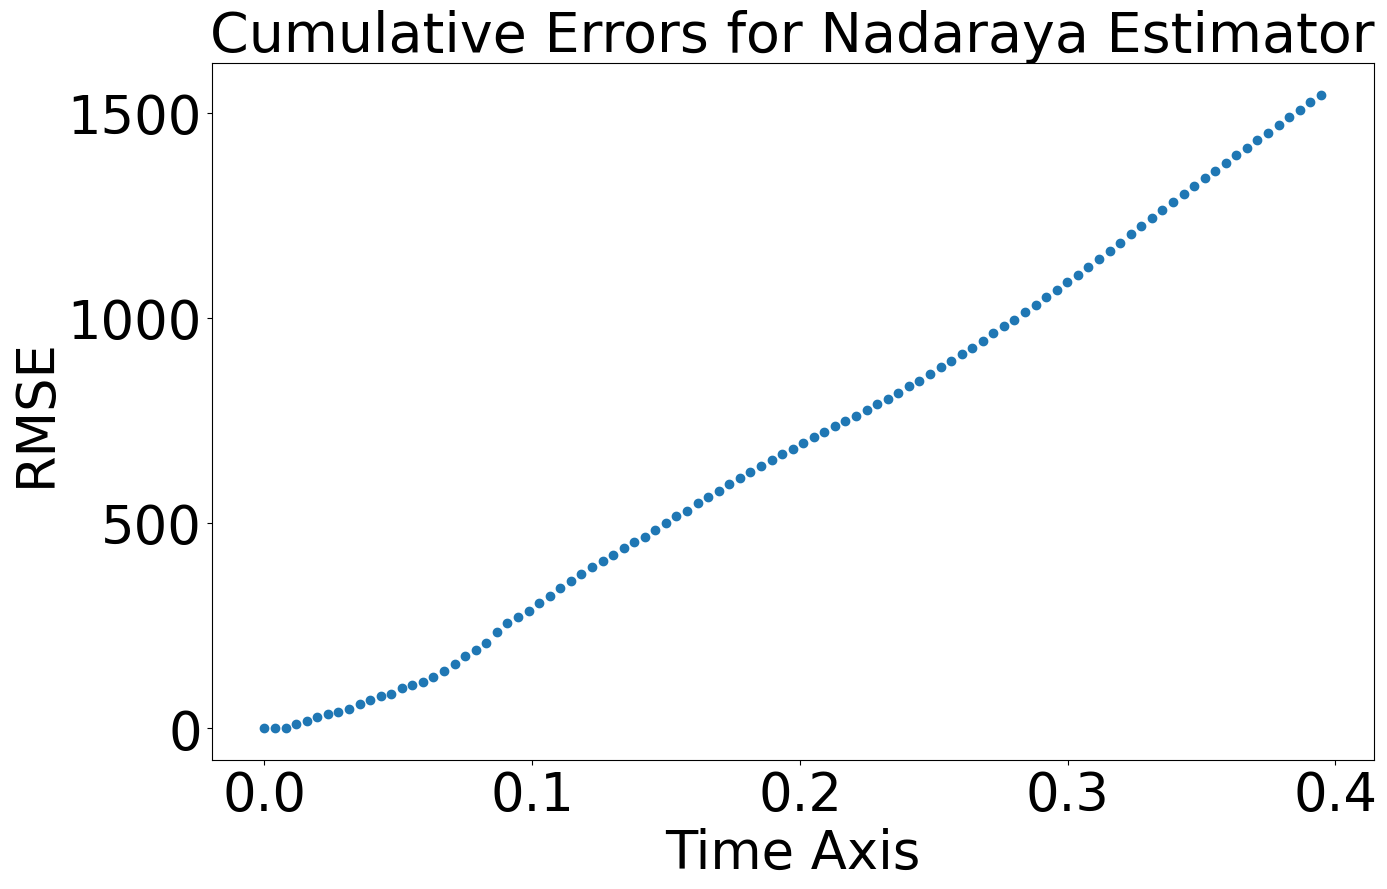

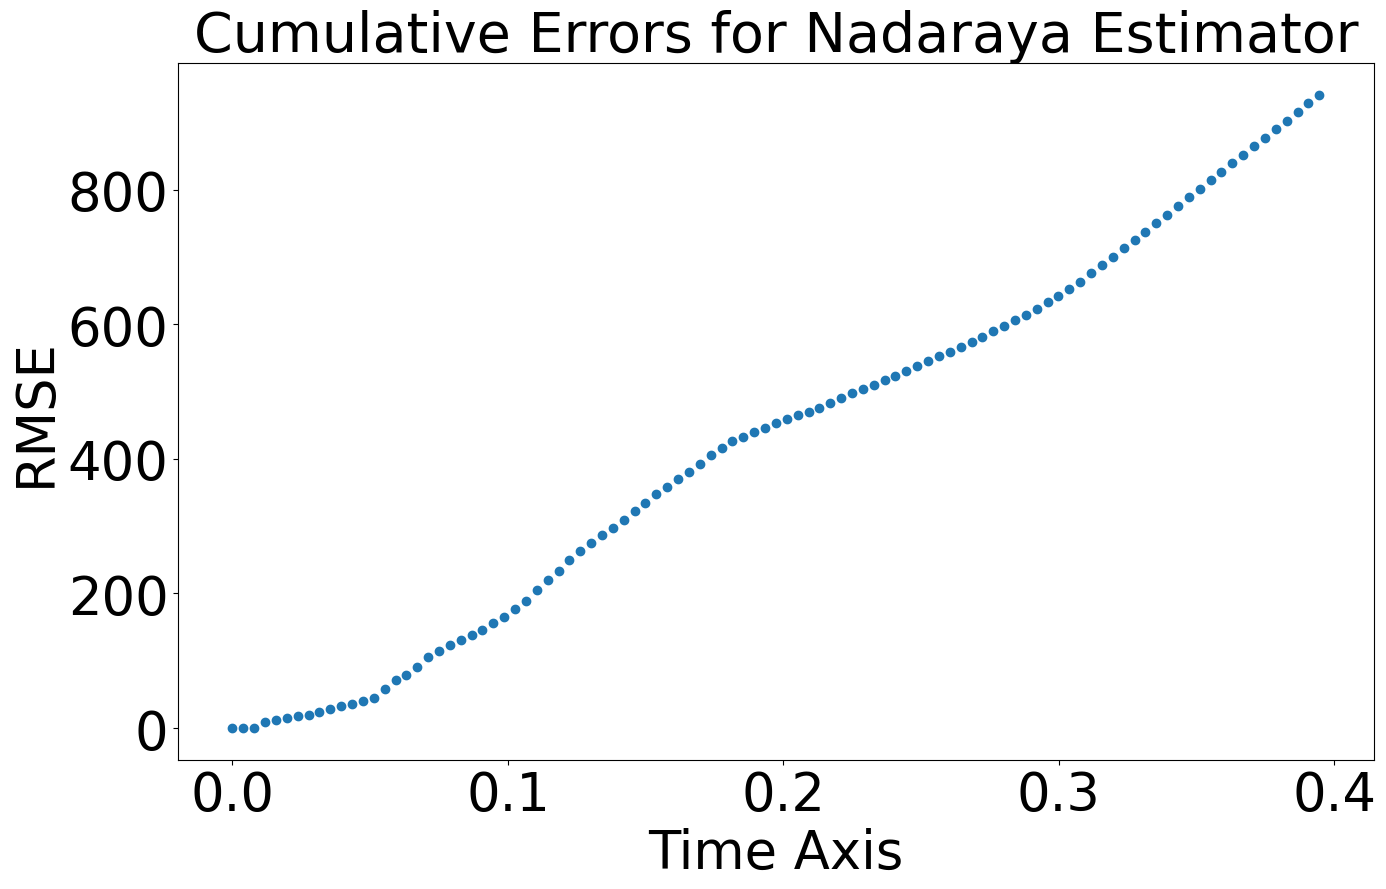

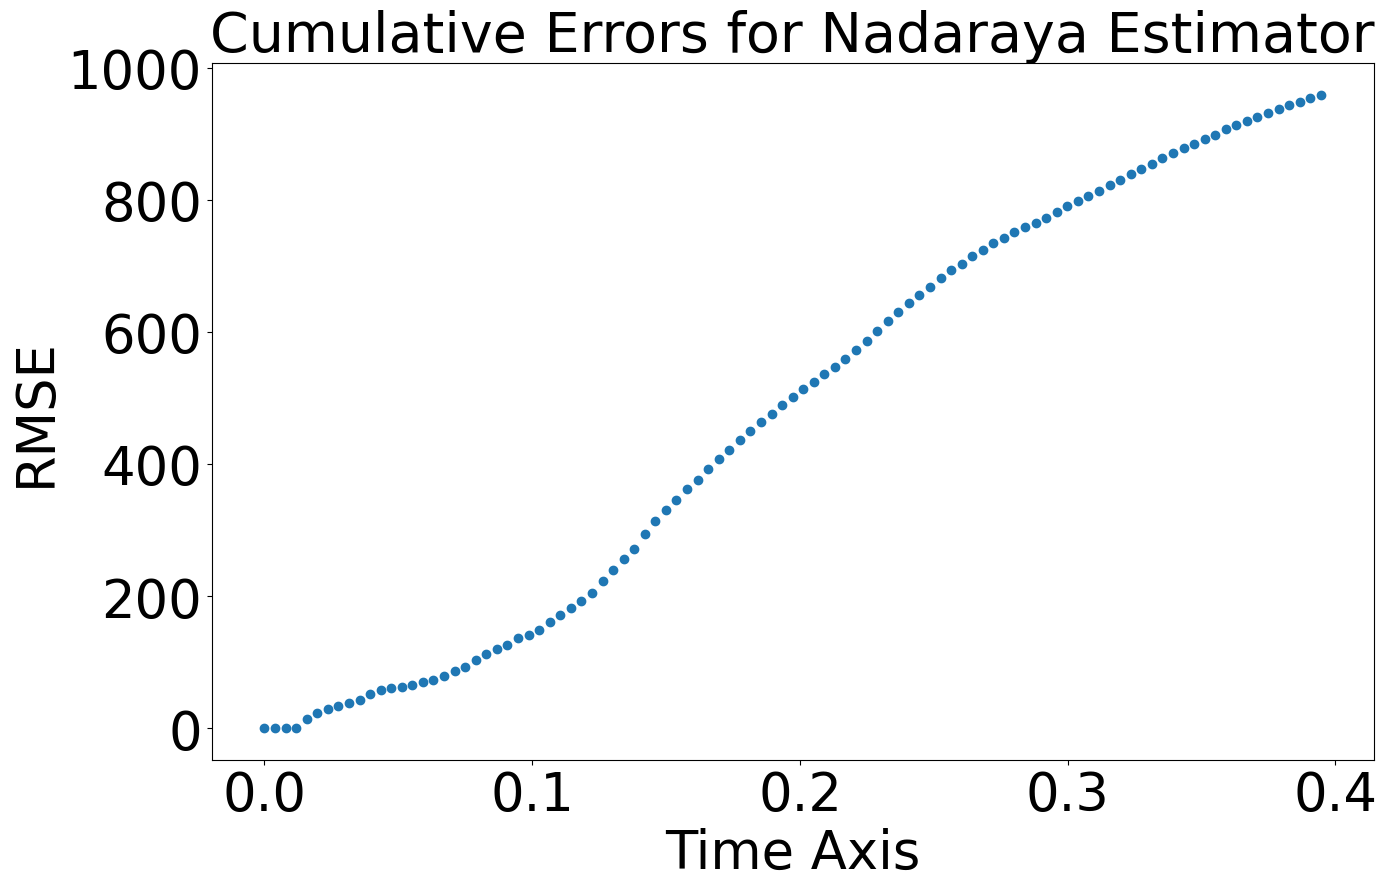

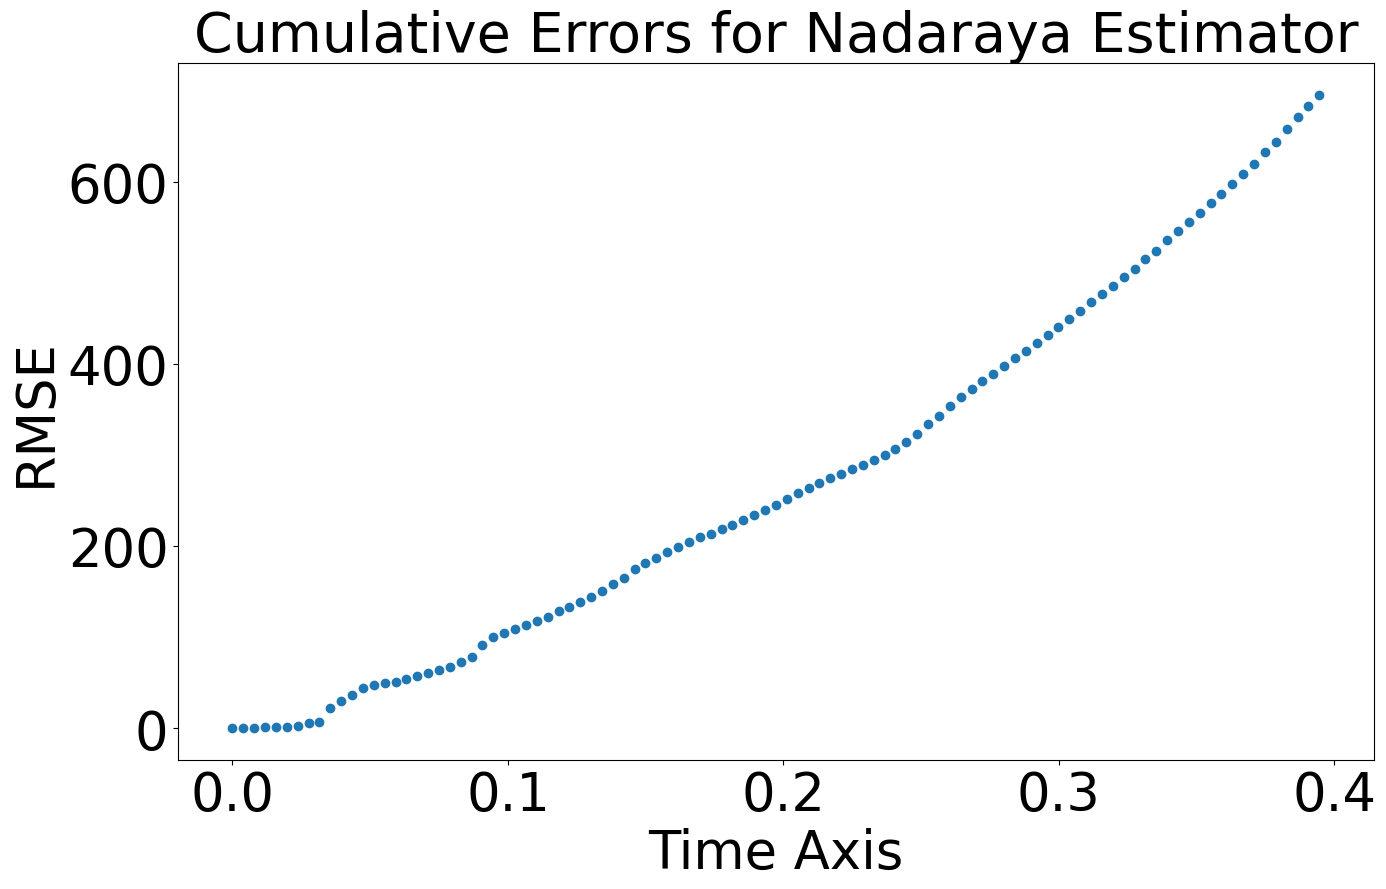

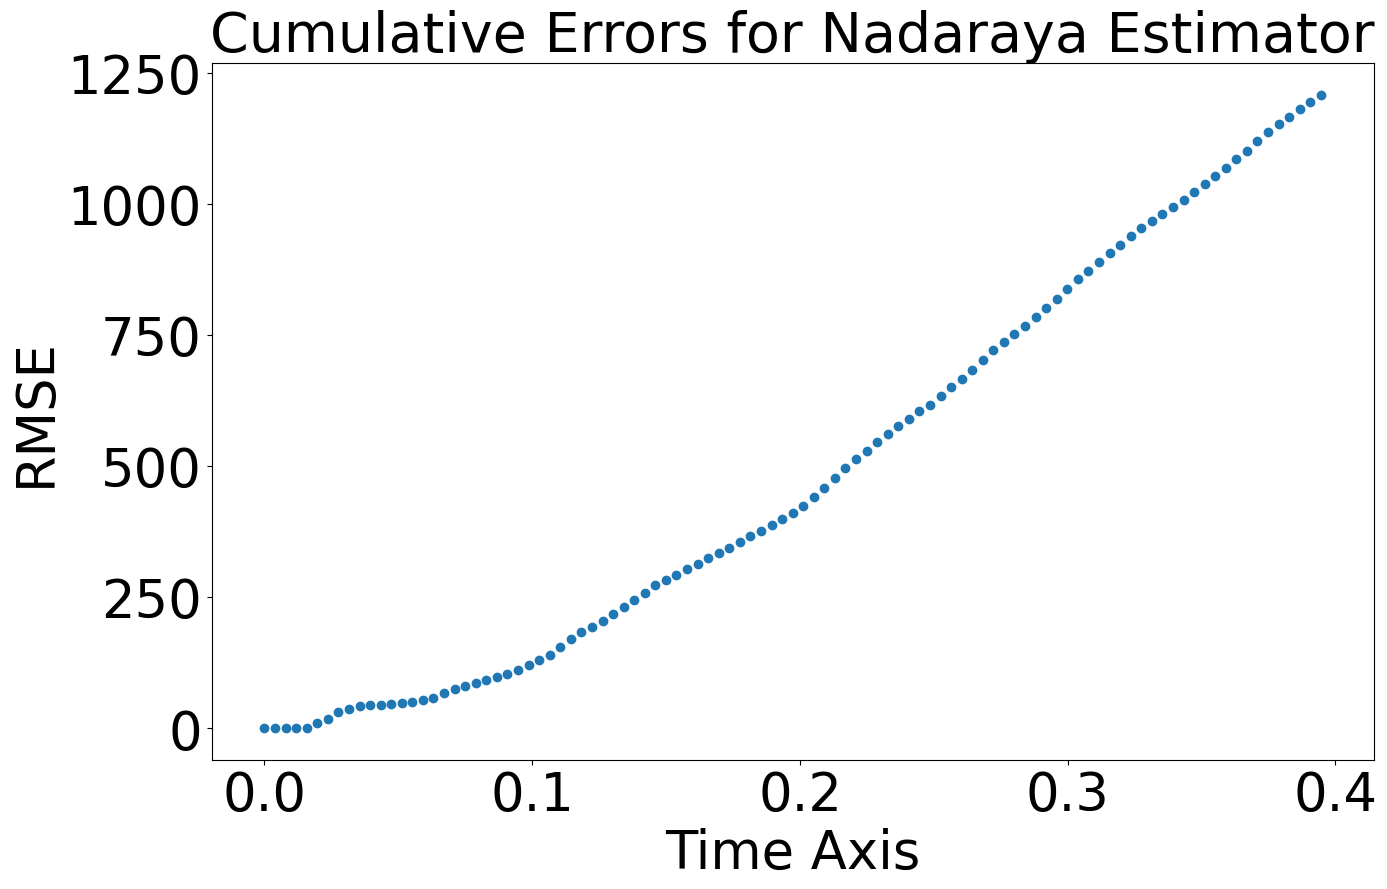

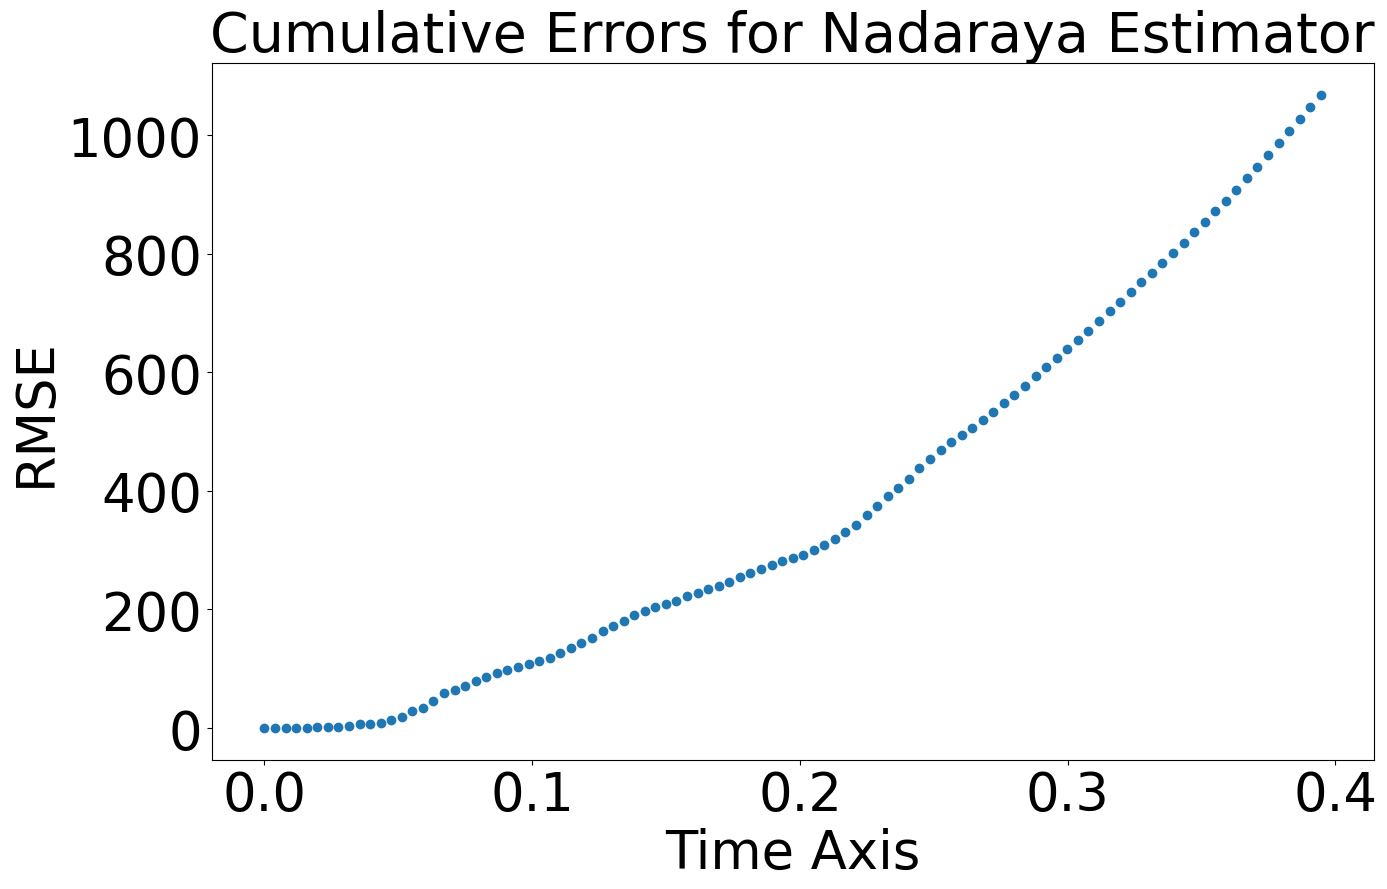

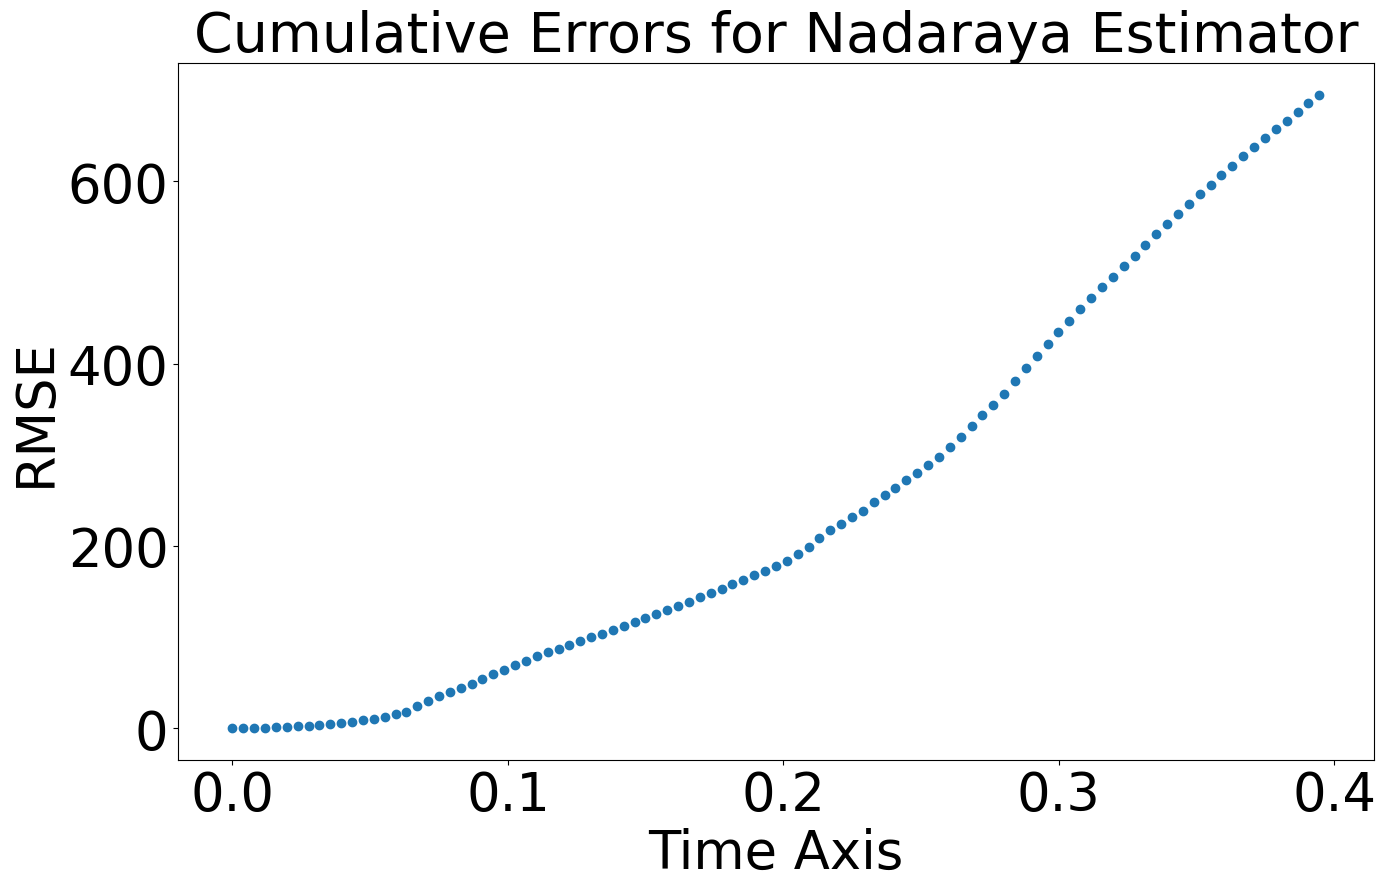

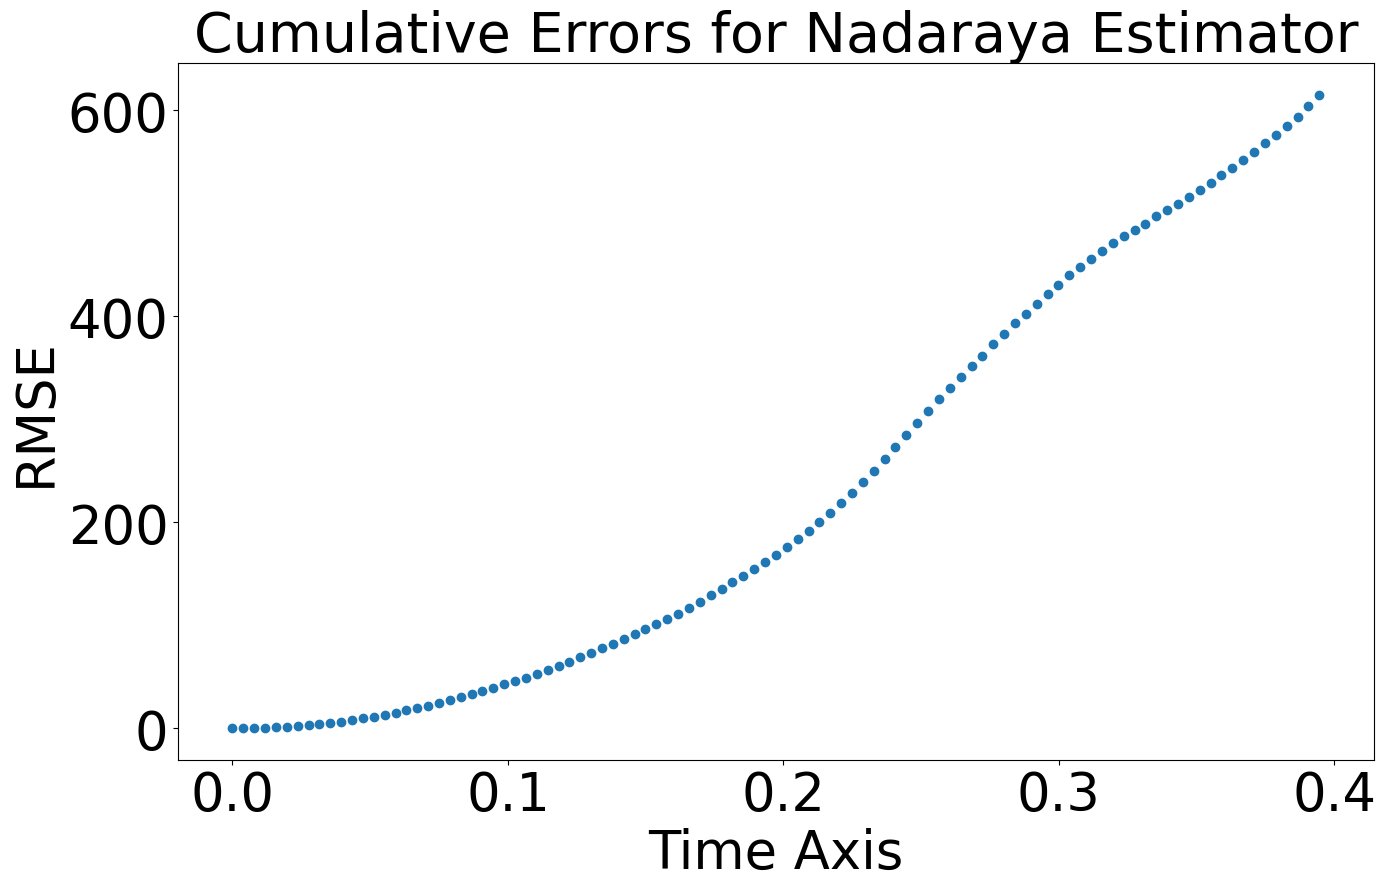

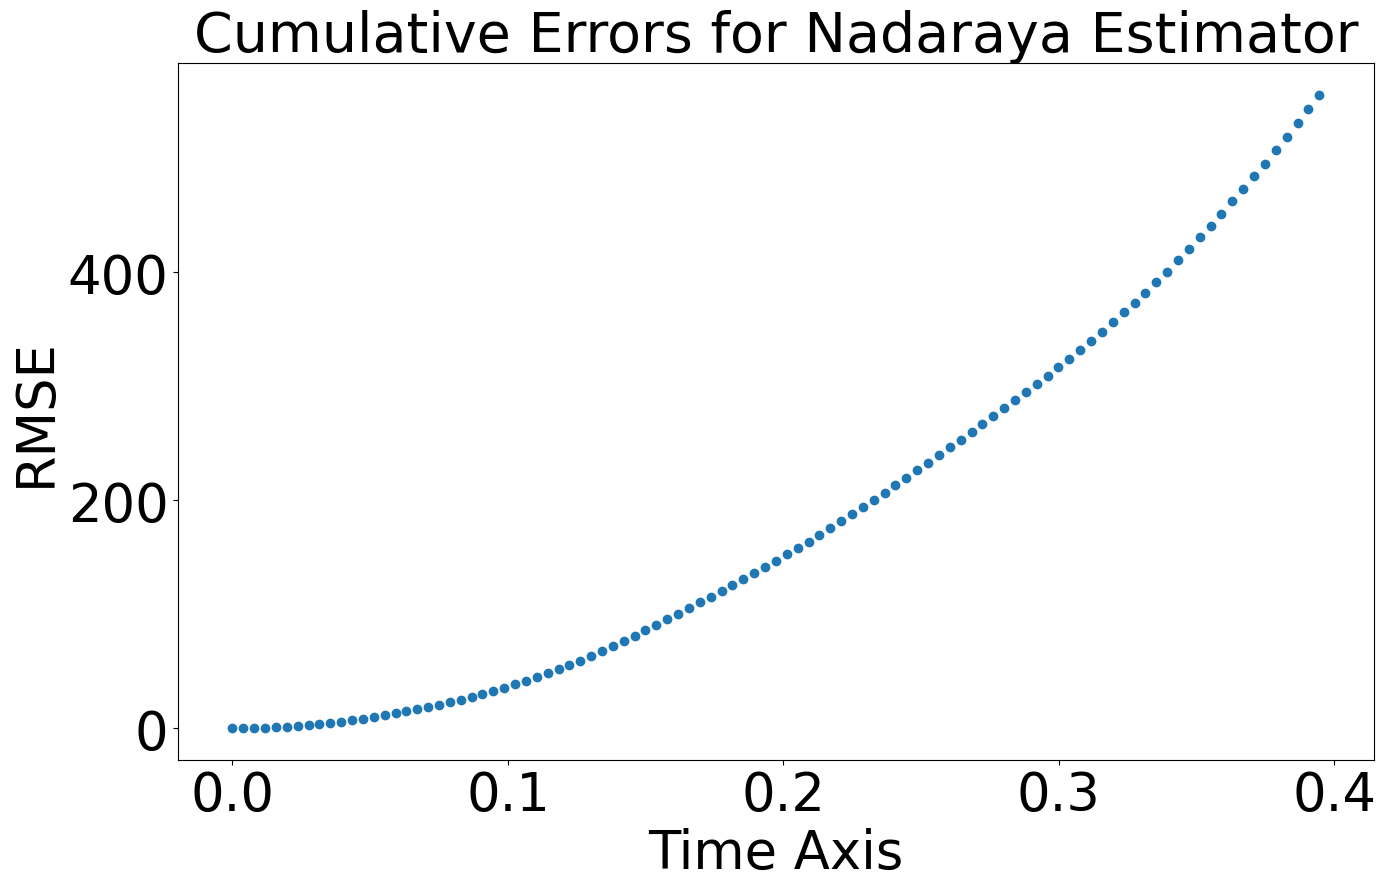

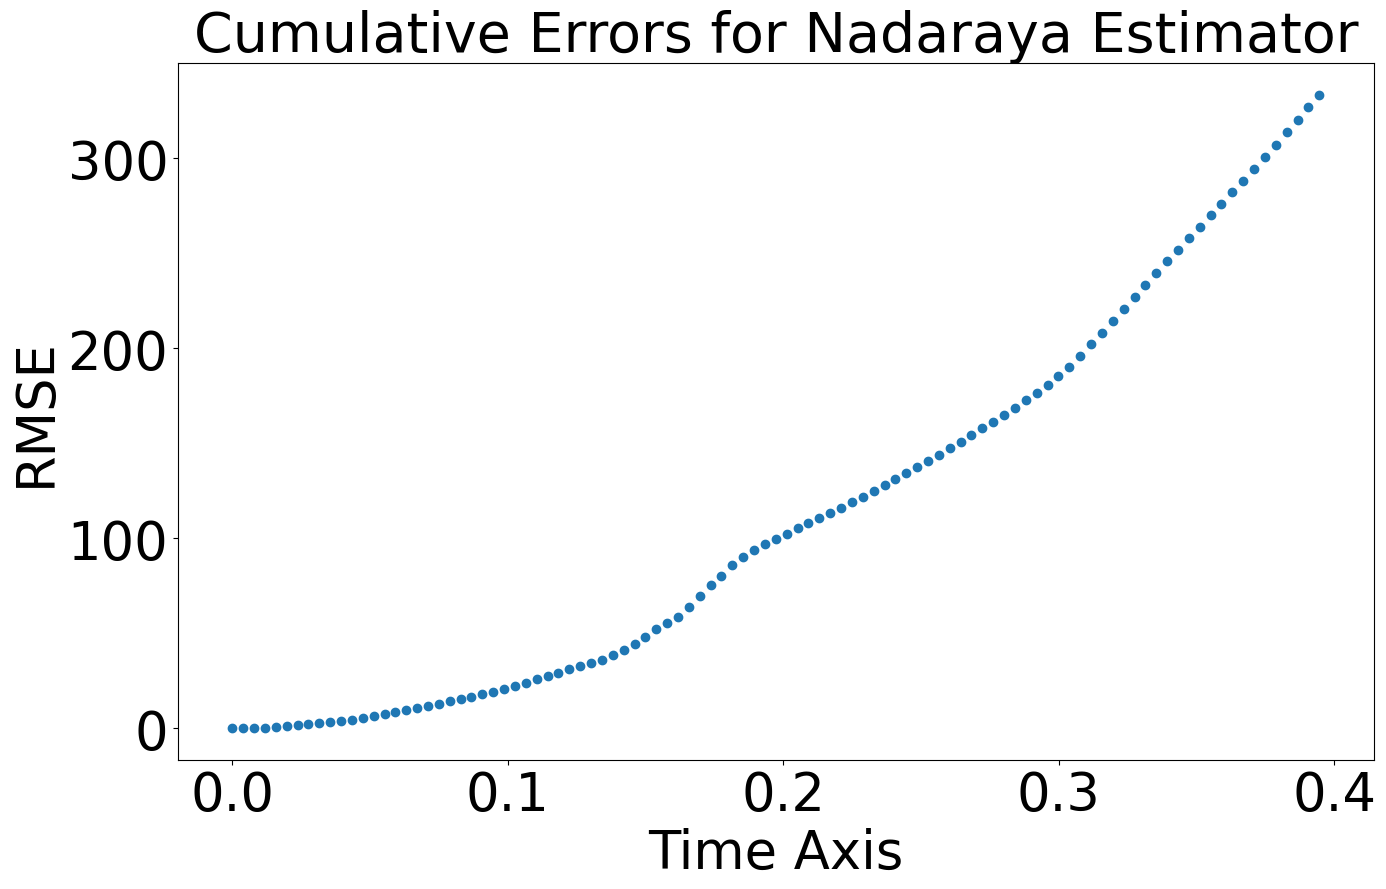

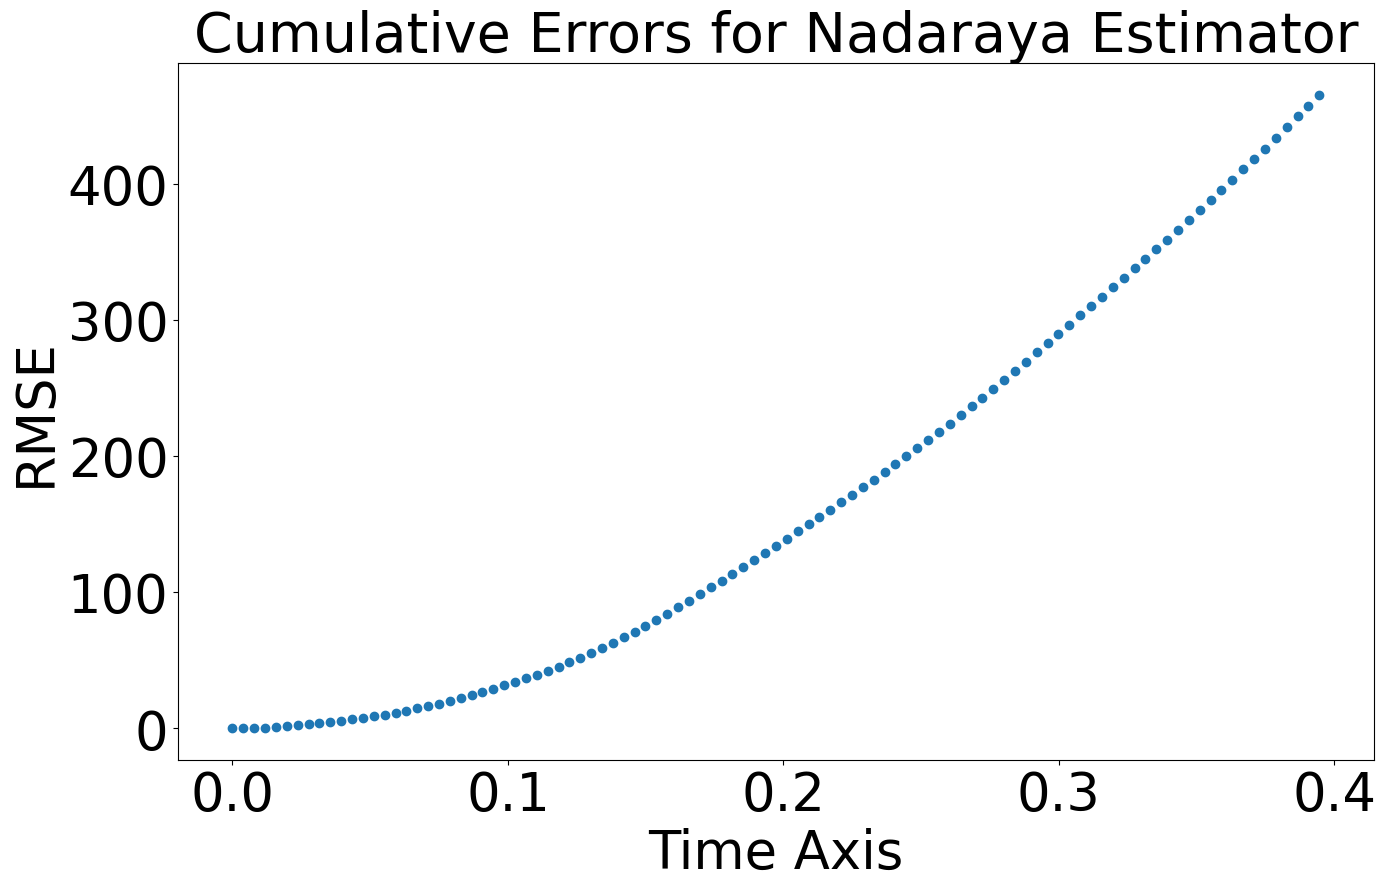

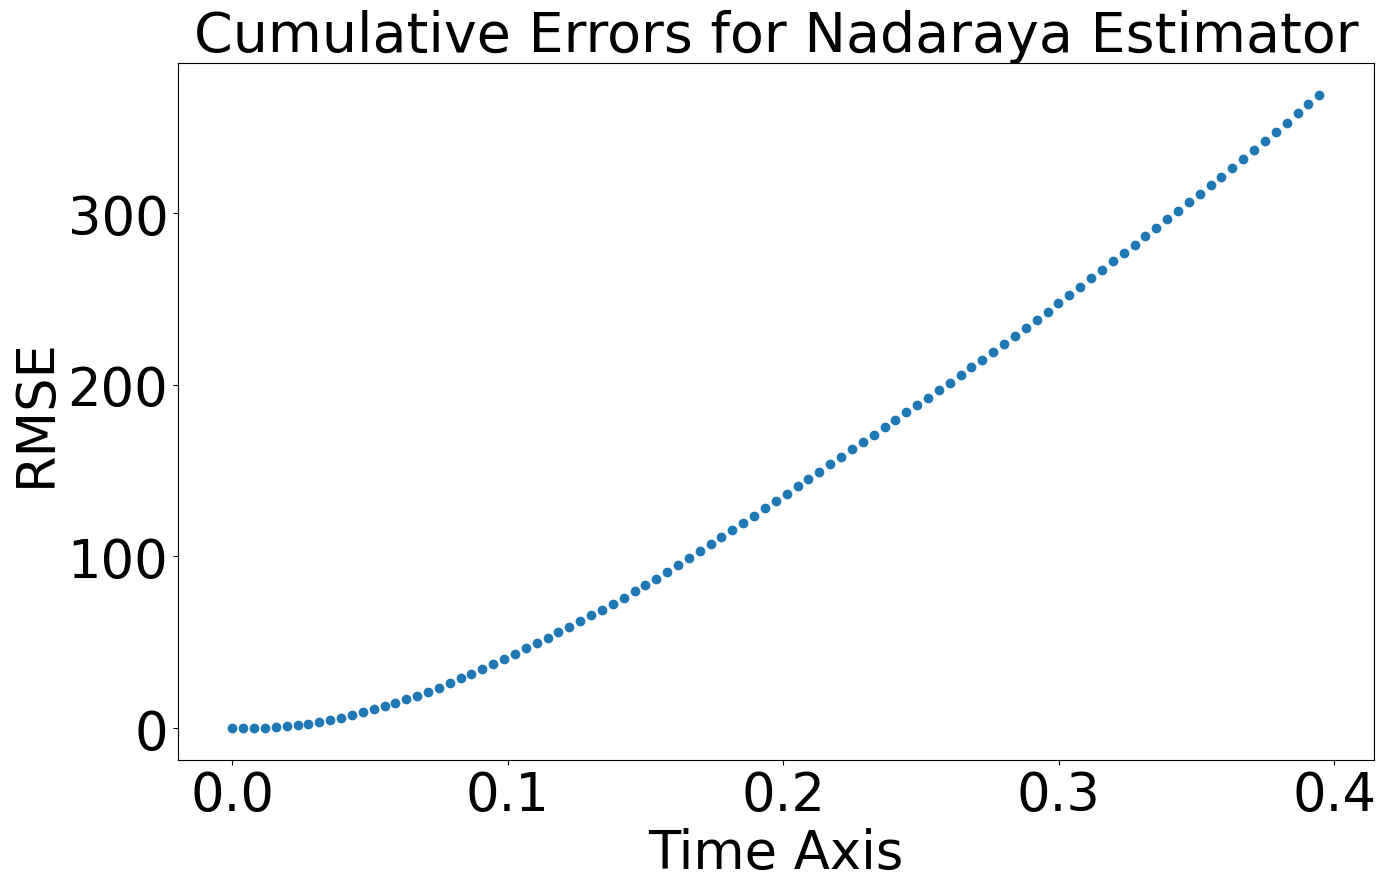

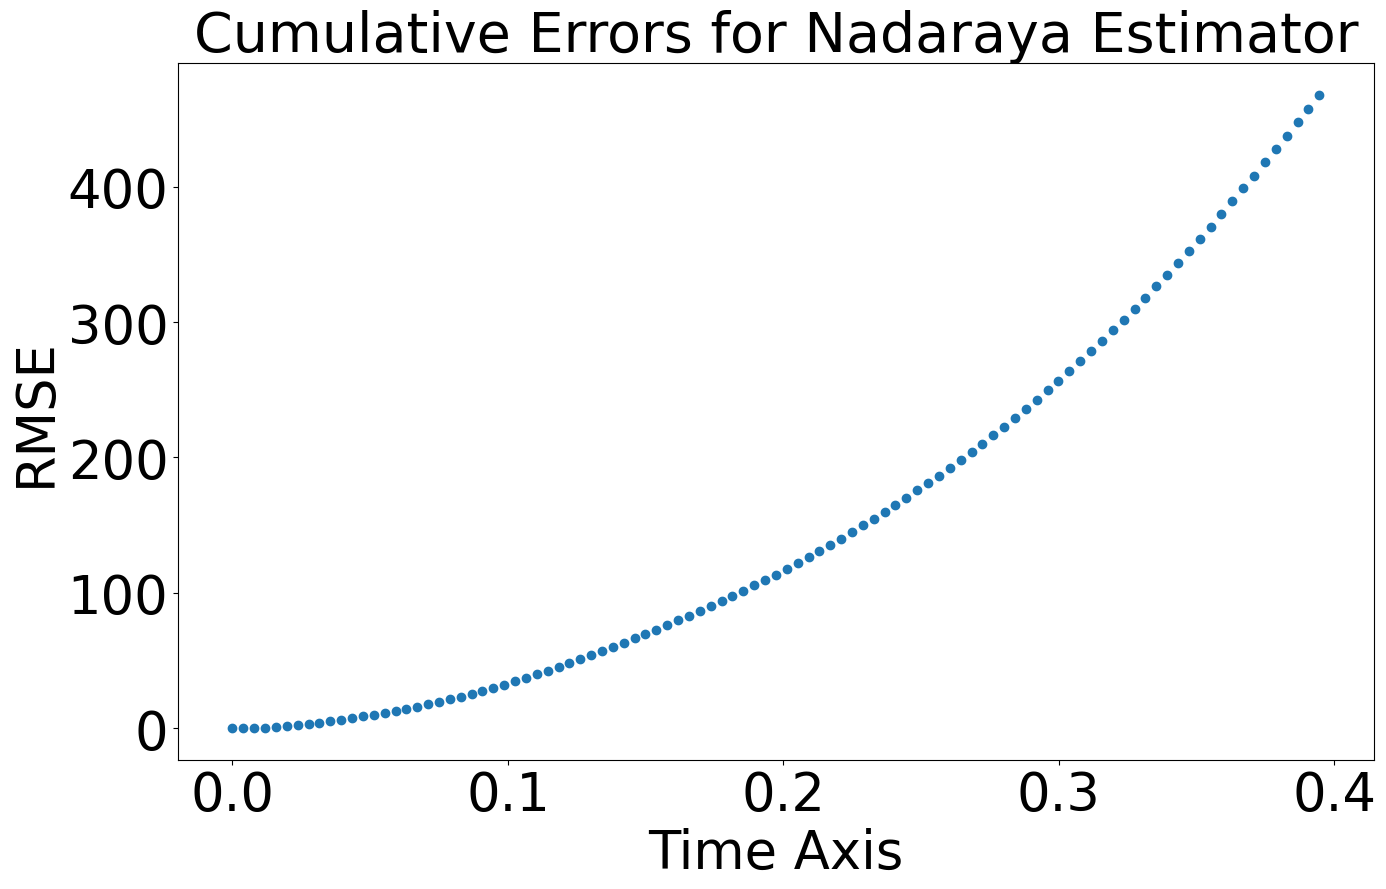

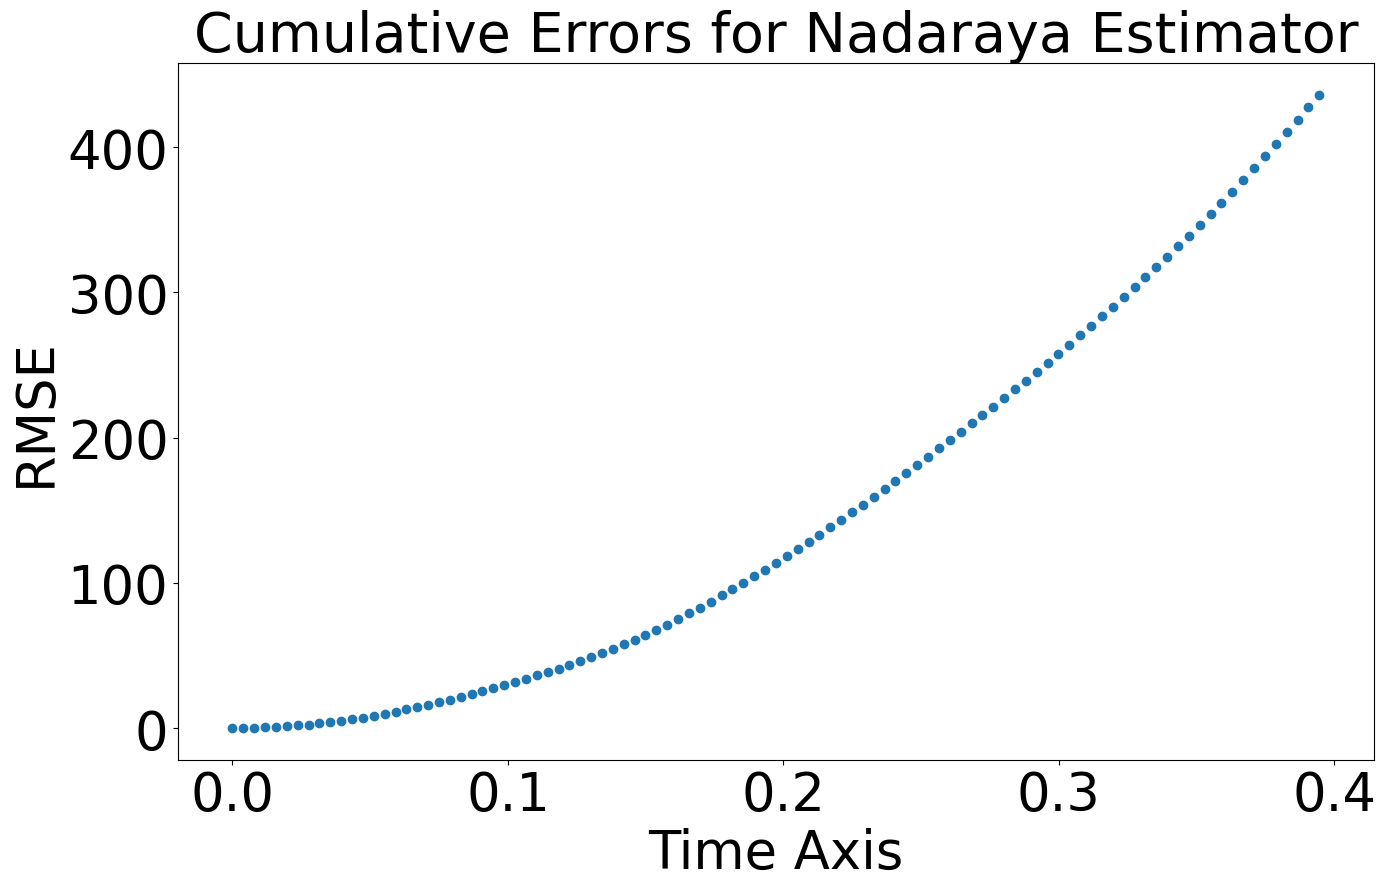

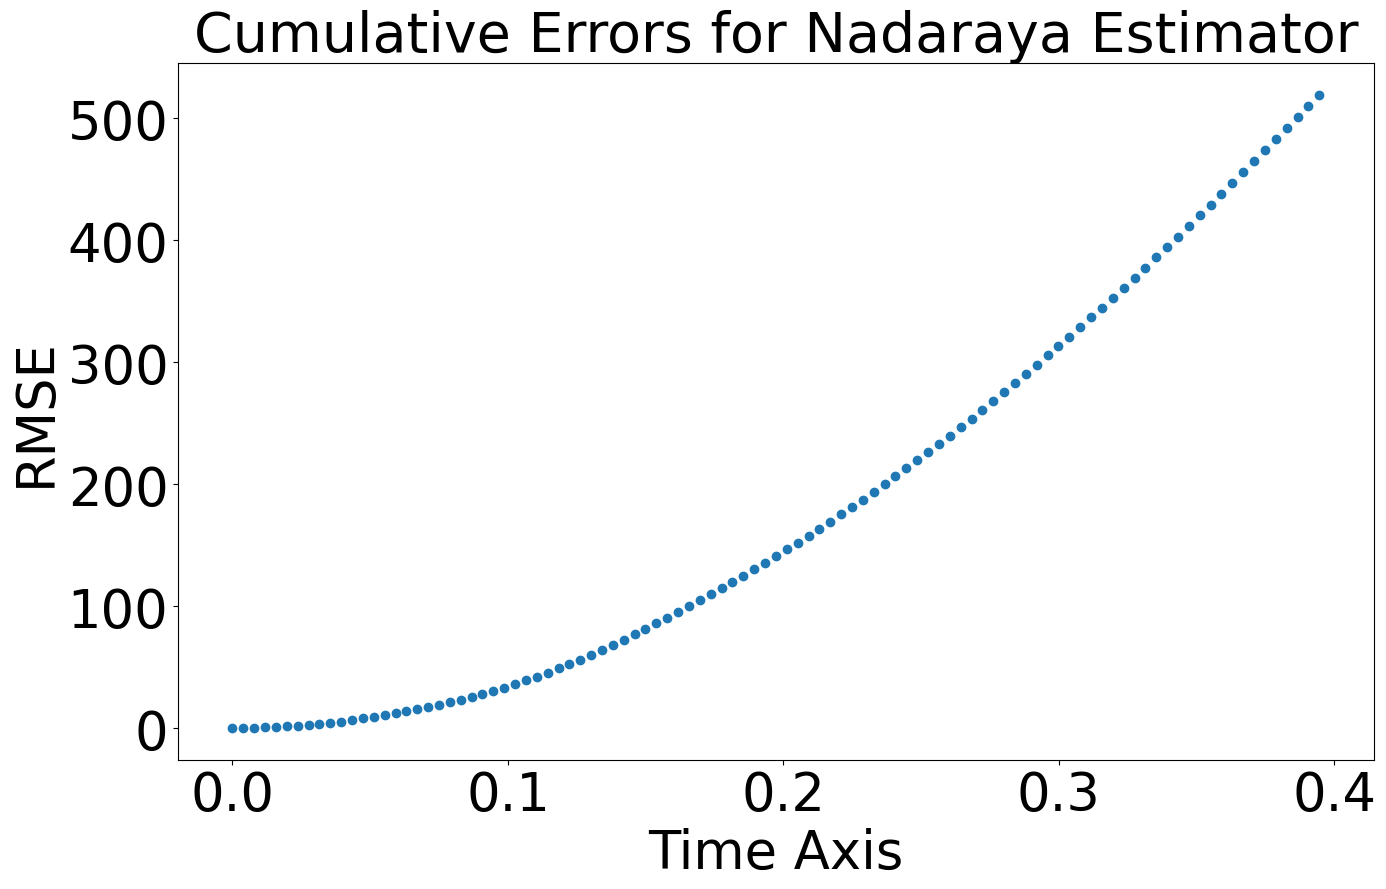

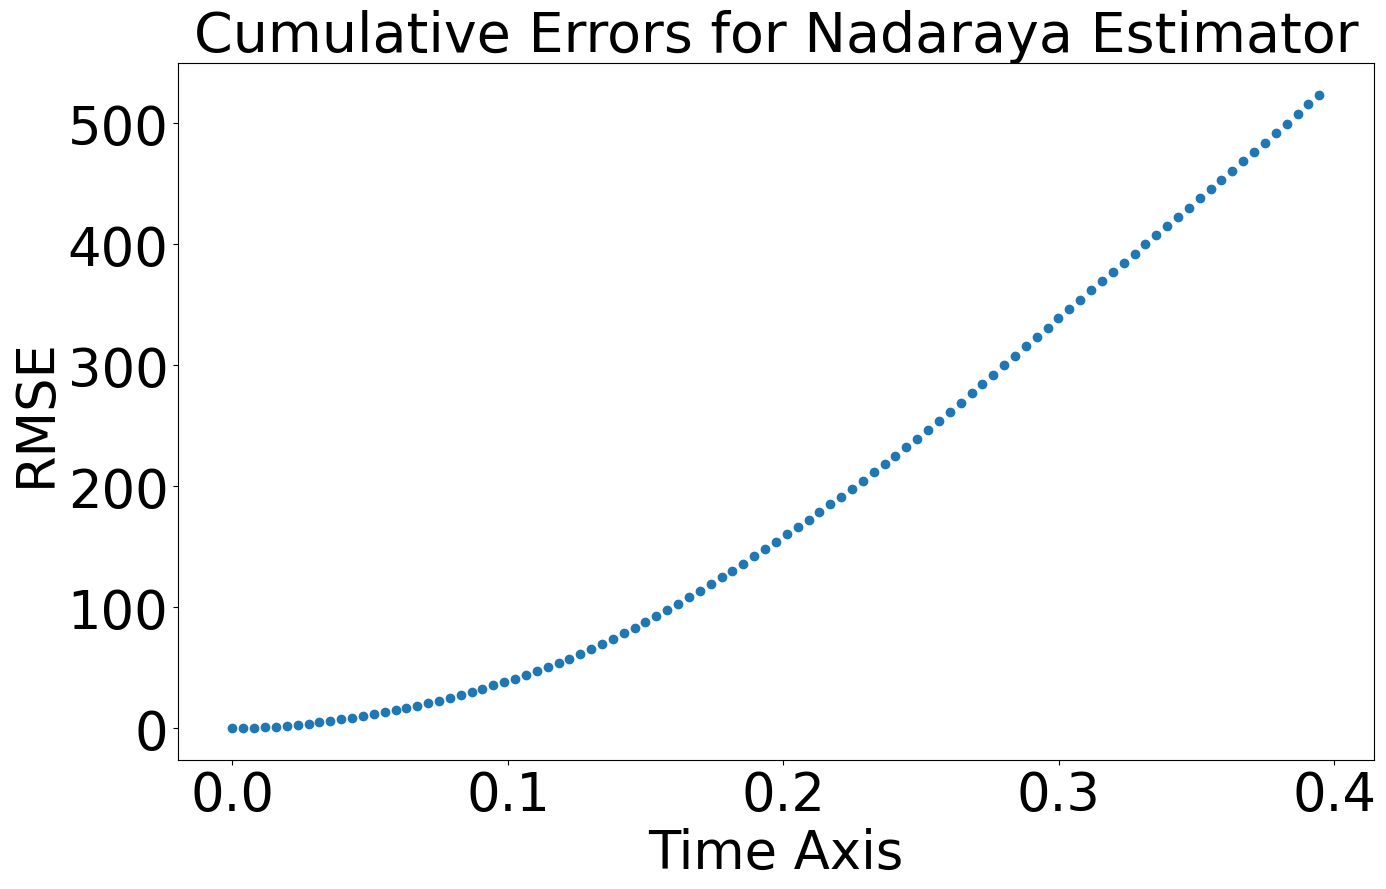

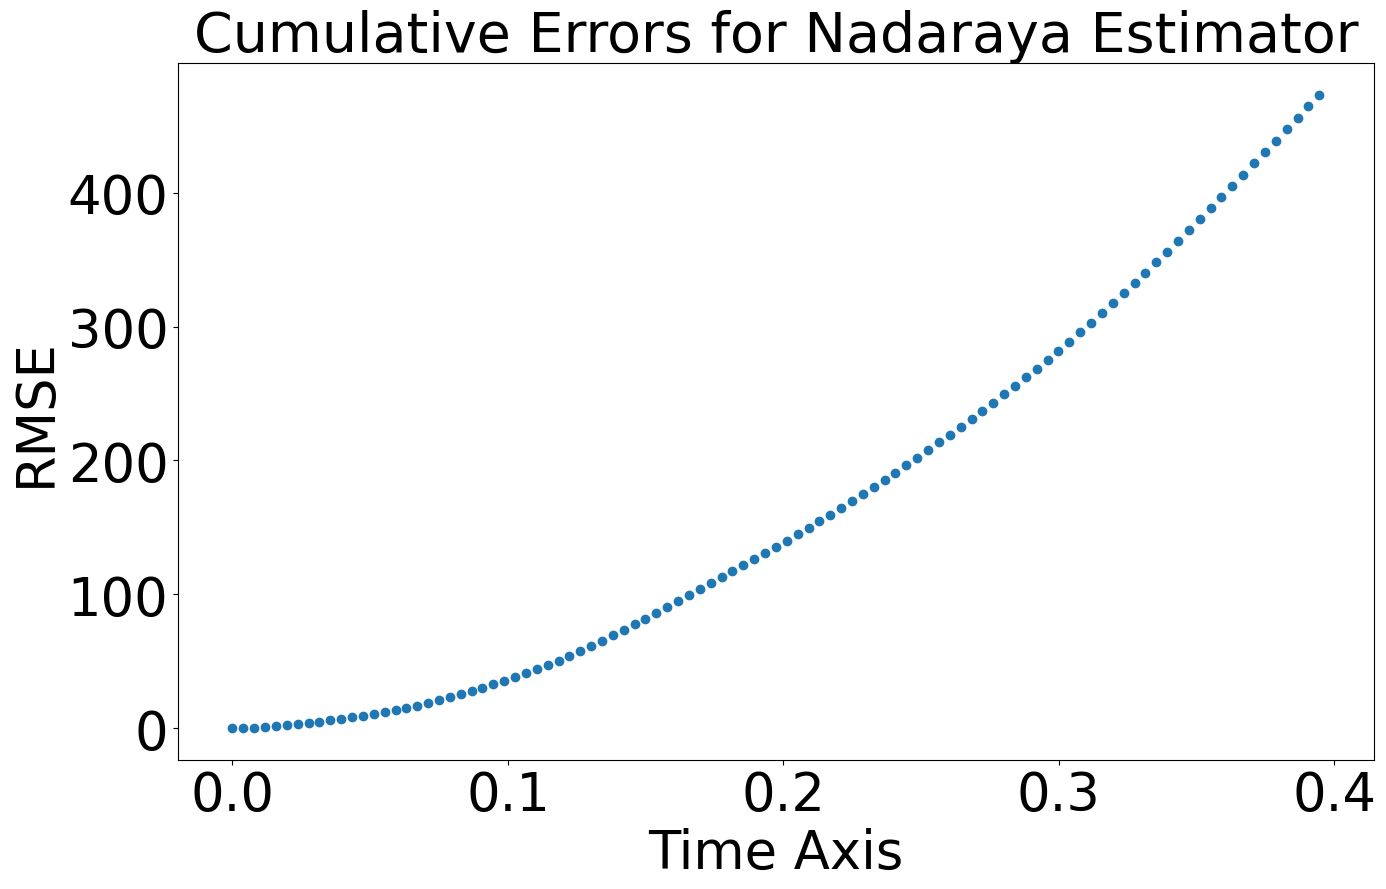

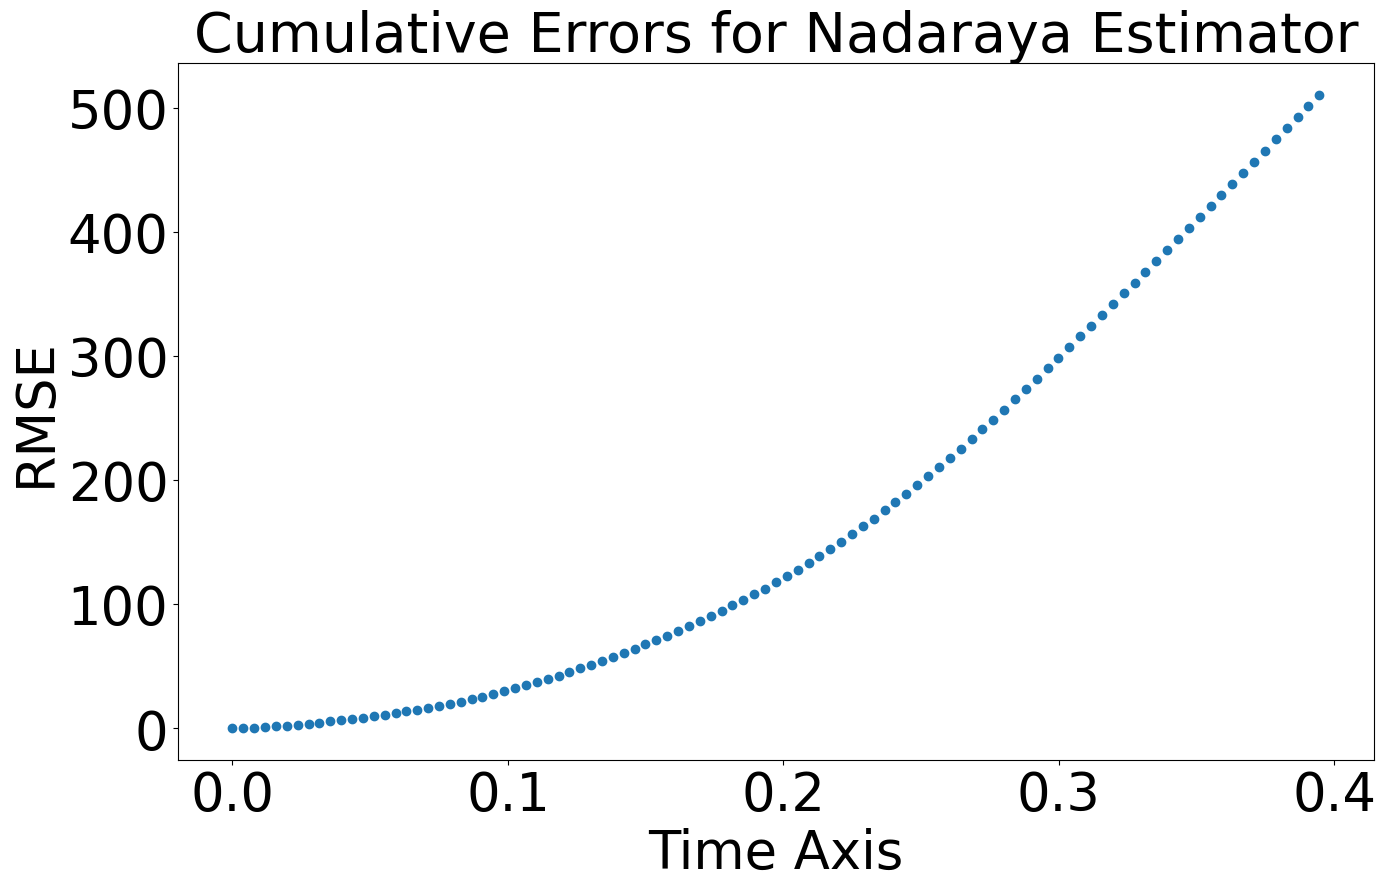

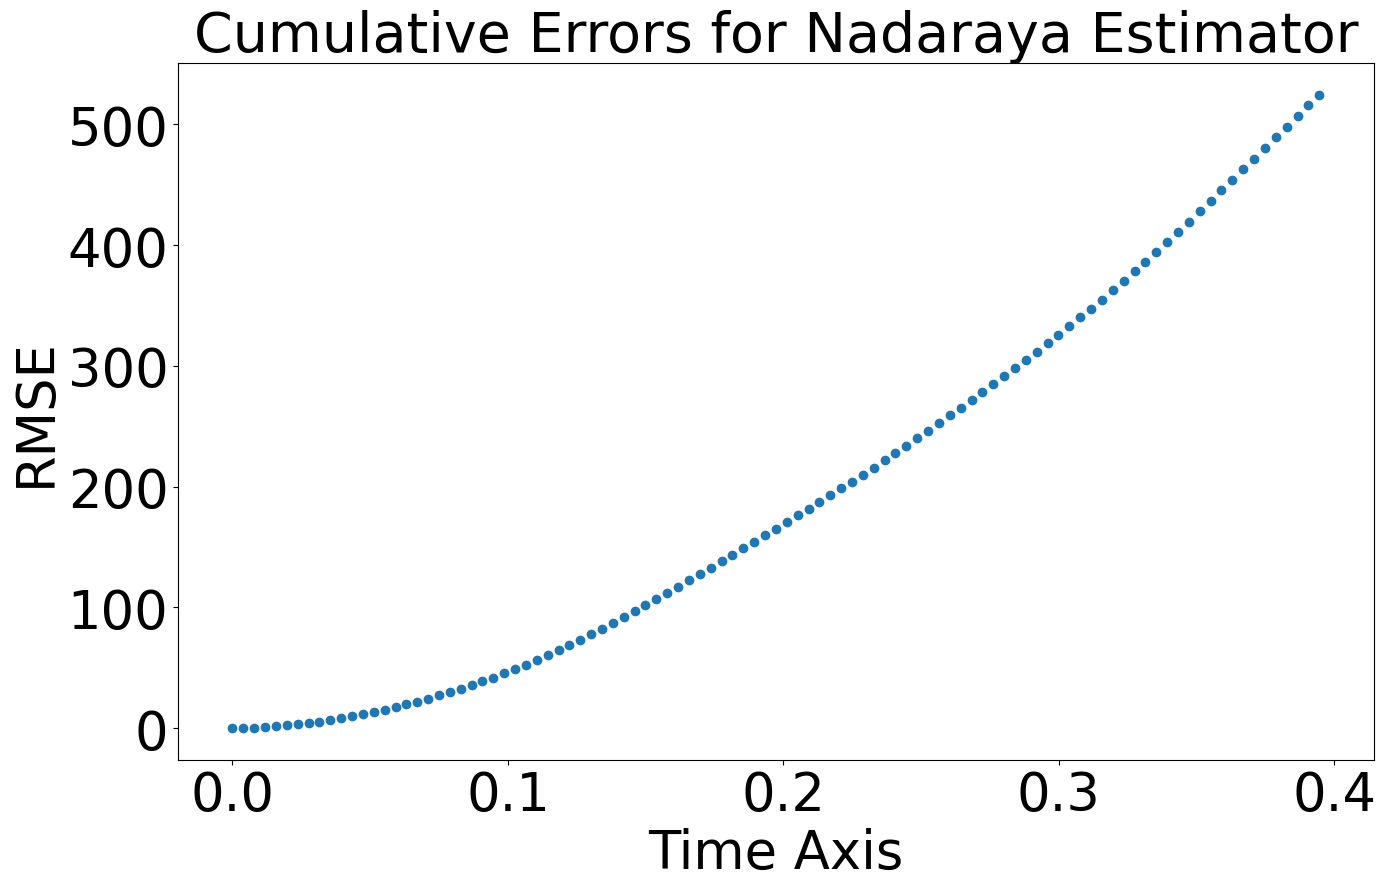

In [62]:
local_bw_rmses = {}
global_bw_rmses = {}
for file in zip(*[global_files, true_files, local_files, bws]):
    bw = file[-1]
    true_states = np.load(file[0])/np.sqrt(config.deltaT)
    global_states= np.load(file[1])/np.sqrt(config.deltaT)
    local_states = np.load(file[2])/np.sqrt(config.deltaT)
    global_errors = np.power(np.mean(np.power(true_states- global_states,2), axis=0), 0.5)
    local_errors = np.power(np.cumsum(np.mean(np.power(true_states- local_states,2), axis=0), axis=0), 0.5)
    local_bw_rmses.update({bw:np.power(np.sum(np.power(local_errors, 2)[-1]), 0.5)})
    global_bw_rmses.update({bw:np.power(np.sum(np.power(global_errors, 2)[-1]), 0.5)})
    """fig, ax = plt.subplots(2,2, figsize=(14,9))
    for dim in range(global_errors.shape[1]):
        if dim == 0: i,j = 0,0
        elif dim == 1: i,j = 0,1
        elif dim == 2: i,j = 1, 0
        else: i,j = 1,1
        ax[i,j].scatter(np.linspace(config.t0,config.deltaT*local_errors.shape[0],local_errors.shape[0]), local_errors[:, dim])
        ax[i, j].set_suptitle(f"Bandwidth {round(bw, 6)}")
        ax[i,j].set_title(f"Nadaraya Dimension {dim+1} Drift RMSE", fontsize=20)
        ax[i,j].set_xlabel("Time Axis", fontsize=20)
    plt.show()
    plt.close()"""
    fig, ax = plt.subplots(figsize=(14,9))
    total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1), 0.5)
    total_global_errors = np.power(np.sum(np.power(global_errors, 2), axis=1), 0.5)
    ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
    ax.set_title(f"Cumulative Errors for Nadaraya Estimator", fontsize=40)
    ax.set_ylabel("RMSE", fontsize=38)
    ax.set_xlabel("Time Axis", fontsize=38)
    ax.tick_params(labelsize=38)
    plt.tight_layout()
    if bw == bws[10]:
        plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/4DLnz_IIDNadaraya_{config.deltaT:.3e}dT.png",  bbox_inches='tight')
    plt.show()
    plt.close()


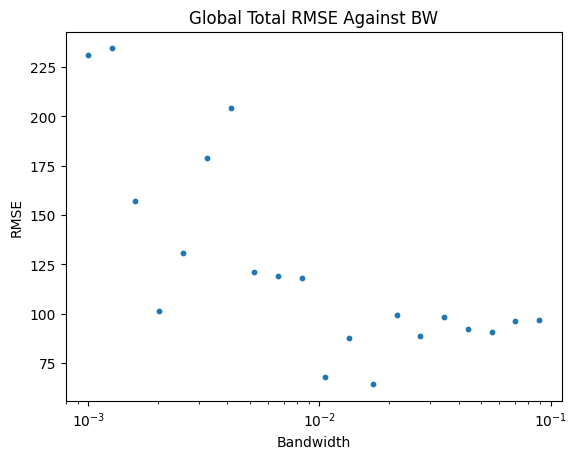

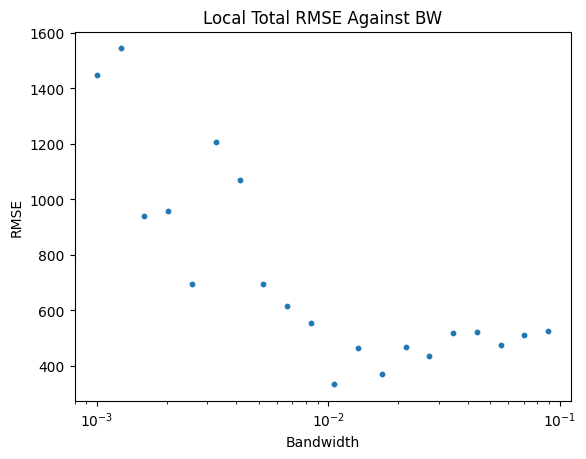

In [63]:
plt.scatter(global_bw_rmses.keys(),global_bw_rmses.values(), s=10)
plt.title("Global Total RMSE Against BW")
plt.xscale("log")
plt.xlabel("Bandwidth")
plt.ylabel("RMSE")
plt.show()
plt.close()
plt.scatter(local_bw_rmses.keys(),local_bw_rmses.values(), s=10)
plt.title("Local Total RMSE Against BW")
plt.xscale("log")
plt.xlabel("Bandwidth")
plt.ylabel("RMSE")
plt.show()
plt.close()